# ARS 
This notebook is a recreation of the ARS (Augmented Random Search) reinforcement learning algorithm example workflow tutorial by Colin Skow in [this repository](https://github.com/colinskow/move37/blob/master/ars/ars.py). 

In [2]:
import os
import numpy as np
import gym
from gym import wrappers
import safety_gym

import time

In [3]:
# A look at different options for gym environments
print(gym.envs.registry.all())

dict_values([EnvSpec(Copy-v0), EnvSpec(RepeatCopy-v0), EnvSpec(ReversedAddition-v0), EnvSpec(ReversedAddition3-v0), EnvSpec(DuplicatedInput-v0), EnvSpec(Reverse-v0), EnvSpec(CartPole-v0), EnvSpec(CartPole-v1), EnvSpec(MountainCar-v0), EnvSpec(MountainCarContinuous-v0), EnvSpec(Pendulum-v0), EnvSpec(Acrobot-v1), EnvSpec(LunarLander-v2), EnvSpec(LunarLanderContinuous-v2), EnvSpec(BipedalWalker-v3), EnvSpec(BipedalWalkerHardcore-v3), EnvSpec(CarRacing-v0), EnvSpec(Blackjack-v0), EnvSpec(KellyCoinflip-v0), EnvSpec(KellyCoinflipGeneralized-v0), EnvSpec(FrozenLake-v0), EnvSpec(FrozenLake8x8-v0), EnvSpec(CliffWalking-v0), EnvSpec(NChain-v0), EnvSpec(Roulette-v0), EnvSpec(Taxi-v3), EnvSpec(GuessingGame-v0), EnvSpec(HotterColder-v0), EnvSpec(Reacher-v2), EnvSpec(Pusher-v2), EnvSpec(Thrower-v2), EnvSpec(Striker-v2), EnvSpec(InvertedPendulum-v2), EnvSpec(InvertedDoublePendulum-v2), EnvSpec(HalfCheetah-v2), EnvSpec(HalfCheetah-v3), EnvSpec(Hopper-v2), EnvSpec(Hopper-v3), EnvSpec(Swimmer-v2), EnvSp

In [4]:
# Hyperparameter class. Makes it easy to keep training initialization organized
class HP():
    # Hyperparameters
    def __init__(self,
                 nb_steps=1000,
                 episode_length=2000,
                 learning_rate=0.02,
                 num_deltas=32,
                 num_best_deltas=16,
                 noise=0.03,
                 seed=1,
                 env_name = 'Safexp-PointGoal0-v0',
                 #env_name = 'Humanoid-v2',
                 #env_name = 'HalfCheetah-v2',
                 record_every=50):

        self.nb_steps = nb_steps
        self.episode_length = episode_length
        self.learning_rate = learning_rate
        self.num_deltas = num_deltas
        self.num_best_deltas = num_best_deltas
        assert self.num_best_deltas <= self.num_deltas
        self.noise = noise
        self.seed = seed
        self.env_name = env_name
        self.record_every = record_every

In [5]:
# Creates running statistical distributions for observations
class Normalizer():
    # Normalizes the inputs
    def __init__(self, nb_inputs):
        self.n = np.zeros(nb_inputs)
        self.mean = np.zeros(nb_inputs)
        self.mean_diff = np.zeros(nb_inputs)
        self.var = np.zeros(nb_inputs)

    def observe(self, x):
        self.n += 1.0
        last_mean = self.mean.copy()
        self.mean += (x - self.mean) / self.n
        self.mean_diff += (x - last_mean) * (x - self.mean)
        self.var = (self.mean_diff / self.n).clip(min = 1e-2)

    def normalize(self, inputs):
        obs_mean = self.mean
        obs_std = np.sqrt(self.var)
        return (inputs - obs_mean) / obs_std

In [6]:
# Policy class. Keeps track of weights and contains methods related to updating them.
class Policy():
    def __init__(self, input_size, output_size, hp):
      #this creates a zero matrix of rows,column
        self.theta = np.zeros((output_size, input_size))
        self.hp = hp

    def evaluate(self, input, delta = None, direction = None):
        if direction is None:
          #.dot is numpy function for dot product
            return self.theta.dot(input)
        elif direction == "+":
            return (self.theta + self.hp.noise * delta).dot(input)
        elif direction == "-":
            return (self.theta - self.hp.noise * delta).dot(input)

    def sample_deltas(self):
        return [np.random.randn(*self.theta.shape) for _ in range(self.hp.num_deltas)]
#This code above here is super important 
#This is how the weights are updated according to which configuration of weights led to the biggest reward
    def update(self, rollouts, sigma_rewards):
        # sigma_rewards is the standard deviation of the rewards
        step = np.zeros(self.theta.shape)
        for r_pos, r_neg, delta in rollouts:
            step += (r_pos - r_neg) * delta
        self.theta += self.hp.learning_rate / (self.hp.num_best_deltas * sigma_rewards) * step

In [7]:
# Skow's ARS agent which makes use of the above classes
class ARSTrainer():
    def __init__(self,
                 hp=None,
                 input_size=None,
                 output_size=None,
                 normalizer=None,
                 policy=None,
                 monitor_dir=None):

        self.hp = hp or HP()
        np.random.seed(self.hp.seed)
        self.env = gym.make(self.hp.env_name)
        if monitor_dir is not None:
            should_record = lambda i: self.record_video
            self.env = wrappers.Monitor(self.env, monitor_dir, video_callable=should_record, force=True)
        self.hp.episode_length = self.hp.episode_length
        self.input_size = input_size or self.env.observation_space.shape[0]
        self.output_size = output_size or self.env.action_space.shape[0]
        self.normalizer = normalizer or Normalizer(self.input_size)
        self.policy = policy or Policy(self.input_size, self.output_size, self.hp)
        self.record_video = False
        self.history = {}
        self.history['step'] = []
        self.history['reward'] = []

    # Explore the policy on one specific direction and over one episode
    def explore(self, direction=None, delta=None):
        state = self.env.reset()
        done = False
        num_plays = 0.0
        sum_rewards = 0.0
        while not done and num_plays < self.hp.episode_length:
            self.normalizer.observe(state)
            state = self.normalizer.normalize(state)
            action = self.policy.evaluate(state, delta, direction)
            state, reward, done, _ = self.env.step(action)
            reward = max(min(reward, 1), -1)
            sum_rewards += reward
            num_plays += 1
        return sum_rewards

    def train(self):
        for step in range(self.hp.nb_steps):
            # initialize the random noise deltas and the positive/negative rewards
            deltas = self.policy.sample_deltas()
            positive_rewards = [0] * self.hp.num_deltas
            negative_rewards = [0] * self.hp.num_deltas

            # play an episode each with positive deltas and negative deltas, collect rewards
            for k in range(self.hp.num_deltas):
                positive_rewards[k] = self.explore(direction="+", delta=deltas[k])
                negative_rewards[k] = self.explore(direction="-", delta=deltas[k])
                
            # Compute the standard deviation of all rewards
            sigma_rewards = np.array(positive_rewards + negative_rewards).std()

            # Sort the rollouts by the max(r_pos, r_neg) and select the deltas with best rewards
            scores = {k:max(r_pos, r_neg) for k,(r_pos,r_neg) in enumerate(zip(positive_rewards, negative_rewards))}
            order = sorted(scores.keys(), key = lambda x:scores[x], reverse = True)[:self.hp.num_best_deltas]
            rollouts = [(positive_rewards[k], negative_rewards[k], deltas[k]) for k in order]

            # Update the policy
            self.policy.update(rollouts, sigma_rewards)

            # Only record video during evaluation, every n steps
            if step % self.hp.record_every == 0:
                self.record_video = True
            # Play an episode with the new weights and print the score
            reward_evaluation = self.explore()
            print('Step: ', step, 'Reward: ', reward_evaluation)
            self.history['step'].append(step)
            self.history['reward'].append(reward_evaluation)
            # Record score to history every n steps
            #if step % self.hp.record_every == 0:
            #    self.history['step'].append(step)
            #    self.history['reward'].append(reward_evaluation)
            self.record_video = False

In [8]:
def mkdir(base, name):
    path = os.path.join(base, name)
    if not os.path.exists(path):
        os.makedirs(path)
    return path

In [9]:
import datetime

In [10]:
# Run the training process, and time it
start = datetime.datetime.now()
ENV_NAME = 'Safexp-PointGoal0-v0'

videos_dir = mkdir('.', 'videos')
monitor_dir = mkdir(videos_dir, ENV_NAME)

hp = HP(env_name=ENV_NAME)
trainer = ARSTrainer(hp=hp, monitor_dir=monitor_dir)
trainer.train()
end = datetime.datetime.now()
print("Time elapsed:", end-start)

/home/jzhou/.local/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Step:  0 Reward:  0.015026355352706466
Step:  1 Reward:  0.11720874999442277
Step:  2 Reward:  -0.07742225731296215
Step:  3 Reward:  -0.9467251230638265
Step:  4 Reward:  0.15273206156216723
Step:  5 Reward:  1.759633776645321
Step:  6 Reward:  0.05740880700769646
Step:  7 Reward:  1.4671669838421655
Step:  8 Reward:  1.533258470477992
Step:  9 Reward:  -0.16414207659323687
Step:  10 Reward:  1.5691506889651372
Step:  11 Reward:  4.857029644628829
Step:  12 Reward:  -5.367033712871929
Step:  13 Reward:  11.25623114340325
Step:  14 Reward:  12.411972593983773
Step:  15 Reward:  19.493465218564225
Step:  16 Reward:  22.494090405745183
Step:  17 Reward:  21.408171049706656
Step:  18 Reward:  18.699992733025738
Step:  19 Reward:  22.4029068590054
Step:  20 Reward:  23.357434578042362
Step:  21 Reward:  24.705809368864518
Step:  22 Reward:  20.121176665079723
Step:  23 Reward:  23.079231267955176
Step:  24 Reward:  24.05215928784759
Step:  25 Reward:  26.698318889032684
Step:  26 Reward:  

KeyboardInterrupt: 

In [11]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

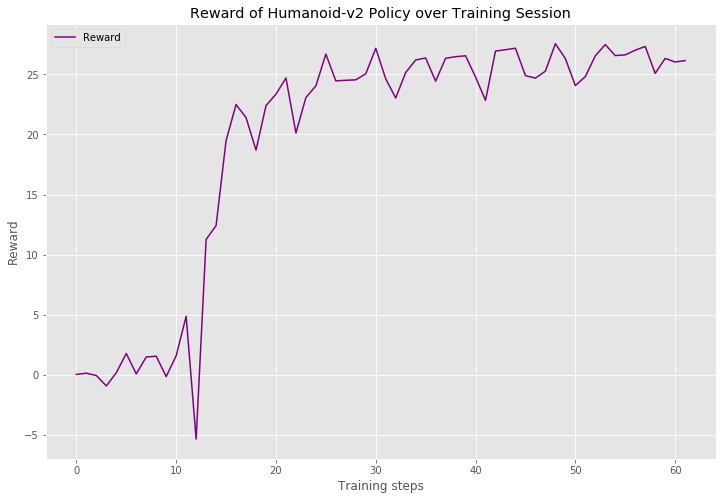

In [12]:
# Visualizing the results of the training
plt.figure(figsize=(12, 8))
plt.plot(trainer.history['step'], trainer.history['reward'], color='purple', label='Reward')
plt.title('Reward of Humanoid-v2 Policy over Training Session')
plt.xlabel('Training steps')
plt.ylabel('Reward')
plt.legend();

In [7]:
# Old training session for backup
start = datetime.datetime.now()
ENV_NAME = 'BipedalWalker-v3'

videos_dir = mkdir('.', 'videos')
monitor_dir = mkdir(videos_dir, ENV_NAME)

hp = HP(env_name=ENV_NAME)
trainer = ARSTrainer(hp=hp, monitor_dir=monitor_dir)
trainer.train()
end = datetime.datetime.now()
print("Time elapsed": end-start)

C:\ProgramData\Anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Step:  0 Reward:  7.201754848995174
Step:  1 Reward:  5.910035305126789
Step:  2 Reward:  -16.325964244665336
Step:  3 Reward:  6.125203420809023
Step:  4 Reward:  3.3585454726996655
Step:  5 Reward:  2.7376328079717105
Step:  6 Reward:  2.9403991365301834
Step:  7 Reward:  2.251316898508081
Step:  8 Reward:  3.1733946027911557
Step:  9 Reward:  2.8667793908242096
Step:  10 Reward:  3.869940680240518
Step:  11 Reward:  4.009611958498104
Step:  12 Reward:  4.07066822153234
Step:  13 Reward:  3.6079994315117068
Step:  14 Reward:  3.522110822229344
Step:  15 Reward:  6.324855491124692
Step:  16 Reward:  5.620884462282735
Step:  17 Reward:  4.568540984787917
Step:  18 Reward:  4.268912809356342
Step:  19 Reward:  4.689601616519572
Step:  20 Reward:  5.06420993279569
Step:  21 Reward:  4.296691491191144
Step:  22 Reward:  3.819935711374087
Step:  23 Reward:  3.7273745162465337
Step:  24 Reward:  4.071615534971969
Step:  25 Reward:  3.4852839784281517
Step:  26 Reward:  4.532317356613178
Ste

Step:  218 Reward:  10.388106388092616
Step:  219 Reward:  11.823639200851623
Step:  220 Reward:  10.95469222514039
Step:  221 Reward:  11.862585806485246
Step:  222 Reward:  10.076116092107862
Step:  223 Reward:  8.781296957015527
Step:  224 Reward:  11.005192637225619
Step:  225 Reward:  9.569805977601522
Step:  226 Reward:  10.297250523721202
Step:  227 Reward:  9.606115799690855
Step:  228 Reward:  9.94702147186791
Step:  229 Reward:  9.456330663307533
Step:  230 Reward:  9.384687600080646
Step:  231 Reward:  10.581306421506945
Step:  232 Reward:  8.51453925220397
Step:  233 Reward:  11.135745582038199
Step:  234 Reward:  11.756716155874196
Step:  235 Reward:  13.243532529536262
Step:  236 Reward:  14.375274265767816
Step:  237 Reward:  13.39892490185419
Step:  238 Reward:  12.115612531765928
Step:  239 Reward:  10.220966168378226
Step:  240 Reward:  9.130378672133194
Step:  241 Reward:  11.349093594738056
Step:  242 Reward:  8.950868095893288
Step:  243 Reward:  10.050049527753812

Step:  431 Reward:  60.21360385019215
Step:  432 Reward:  228.5769552544754
Step:  433 Reward:  237.0667971333898
Step:  434 Reward:  231.69974338292147
Step:  435 Reward:  230.54481316636264
Step:  436 Reward:  188.0104504693506
Step:  437 Reward:  131.4233419998278
Step:  438 Reward:  232.54766627190745
Step:  439 Reward:  245.32803749486615
Step:  440 Reward:  246.92270085973354
Step:  441 Reward:  102.08504680956176
Step:  442 Reward:  209.68956569649373
Step:  443 Reward:  249.38164980023592
Step:  444 Reward:  249.1000471436739
Step:  445 Reward:  238.85877516154142
Step:  446 Reward:  240.30674329386568
Step:  447 Reward:  244.18594709796807
Step:  448 Reward:  225.7375956610299
Step:  449 Reward:  216.62790299425902
Step:  450 Reward:  235.45126288649504
Step:  451 Reward:  114.3491331228251
Step:  452 Reward:  265.2244817757962
Step:  453 Reward:  277.29411381384745
Step:  454 Reward:  174.33626152803936
Step:  455 Reward:  259.9154197749472
Step:  456 Reward:  252.53032526503

Step:  645 Reward:  289.6701627961298
Step:  646 Reward:  292.6090675243363
Step:  647 Reward:  291.4154155182841
Step:  648 Reward:  283.4990474101051
Step:  649 Reward:  289.3130716200317
Step:  650 Reward:  292.60474113672643
Step:  651 Reward:  291.3077820780503
Step:  652 Reward:  291.3916715427709
Step:  653 Reward:  292.6167764912496
Step:  654 Reward:  292.072852386178
Step:  655 Reward:  293.80153479089216
Step:  656 Reward:  292.26907170739315
Step:  657 Reward:  294.44542860978356
Step:  658 Reward:  120.78659668954846
Step:  659 Reward:  289.5363347208893
Step:  660 Reward:  292.1509220797319
Step:  661 Reward:  289.8674394335326
Step:  662 Reward:  286.0142107372029
Step:  663 Reward:  291.7686056037756
Step:  664 Reward:  290.8898126652285
Step:  665 Reward:  289.06337454009594
Step:  666 Reward:  289.2951369707579
Step:  667 Reward:  292.8812687437367
Step:  668 Reward:  291.130918644188
Step:  669 Reward:  287.2646953154002
Step:  670 Reward:  281.4308666700308
Step:  6

Step:  859 Reward:  305.9644709593253
Step:  860 Reward:  307.1572094123591
Step:  861 Reward:  308.4353975151262
Step:  862 Reward:  306.34233544654063
Step:  863 Reward:  306.62627333446255
Step:  864 Reward:  307.07067561544494
Step:  865 Reward:  310.70949918243826
Step:  866 Reward:  308.803012470193
Step:  867 Reward:  311.0815136504547
Step:  868 Reward:  310.898458531386
Step:  869 Reward:  310.52112449558416
Step:  870 Reward:  309.94624905624977
Step:  871 Reward:  310.809152129623
Step:  872 Reward:  311.1880188448004
Step:  873 Reward:  310.446882924464
Step:  874 Reward:  309.98147212616135
Step:  875 Reward:  309.97139449276574
Step:  876 Reward:  309.40632454469164
Step:  877 Reward:  309.6277773431968
Step:  878 Reward:  308.7200068724167
Step:  879 Reward:  307.94695180683436
Step:  880 Reward:  307.2604099081361
Step:  881 Reward:  308.7492317009486
Step:  882 Reward:  310.3033046409393
Step:  883 Reward:  308.5706301090862
Step:  884 Reward:  307.9040156976966
Step: 

In [8]:
trainer.policy.theta

array([[ 0.19773867, -0.43398089,  0.0753329 , -0.40455625, -0.78022785,
        -0.47065727, -0.28752706,  0.02663993, -0.04235575, -0.00839982,
        -0.04940817, -0.14592225,  0.11720849,  0.04220249,  0.09243848,
         0.05408006,  0.217542  ,  0.13483803, -0.10166978, -0.32866835,
        -0.00126649,  0.09081812,  0.06181933,  0.05200593],
       [-0.06774746,  0.07975838,  0.11180235, -0.083668  ,  0.21467017,
        -0.159638  , -0.11771604, -0.28212586, -0.10031455,  0.4626594 ,
         0.47707995, -0.02464654,  0.14722706, -0.03351459, -0.09869358,
        -0.04679419,  0.26850789, -0.22494934,  0.48149819, -0.41699818,
        -0.27997625,  0.25551447, -0.261145  ,  0.06094136],
       [-0.28416599,  0.01871607, -0.13579297,  0.40673224, -0.11451224,
         0.01893984, -0.56593534, -0.11441946,  0.1603778 , -0.63110977,
        -0.09323498,  0.01092114,  0.06647962, -0.11395431,  0.20635529,
        -0.48134119, -0.12073207, -0.02296331, -0.23105415,  0.29713571,
  